Task 1. Predict Cars

The data file contains sample data from cars. Your target for this task is to predict the
price. The end deliverable should be a jupyter notebook. 

    • Clean, describe and visualize the data 
    • Prepare the data for modelling (train/test, encoders etc)
    • Model and evaluate, show metrics and graphs. 
    • Describe your approach at each step.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
data_input = pd.read_csv("csv_files/Spotawheel_case_study.csv")

In [4]:
data_input.head()

,Name,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Age
0,Hyundai i10 Era,60000,Petrol,Manual,2,19.81,1086,68.05,5,2650.0,9
1,Toyota Fortuner 4x2 Manual,73500,Diesel,Manual,1,13.00,2982,168.50,7,22000.0,6
2,Mercedes-Benz E-Class 230 E AT,28888,Petrol,Automatic,1,10.00,2496,157.70,5,7560.0,12
3,Volkswagen Polo Petrol Trendline 1.2L,41000,Petrol,Manual,1,16.47,1198,73.90,5,3100.0,9
4,Land Rover Range Rover Evoque 2.0 TD4 HSE Dynamic,52000,Diesel,Automatic,1,15.68,1999,177.00,5,42000.0,5


The first task that we ought to do is to see the distribution of our labels
for possible outliers that could be extracted from our training dataset.

In [5]:
print("dataset shape is", data_input.shape)
print("unique Owner_Type",len(data_input.loc[:, "Owner_Type"].unique()))
print("unique transmission",len(data_input.loc[:, "Transmission"].unique()))
print("unique fuel type",len(data_input.loc[:, "Fuel_Type"].unique()))

dataset shape is (4907, 11)
unique Owner_Type 4
unique transmission 2
unique fuel type 4


In [6]:
label_name = "Price"
categorical_variables = ["Fuel_Type", "Transmission", "Owner_Type"]
continuous_variables = ["Kilometers_Driven", "Mileage", "Power", "Engine", "Seats"]

In [7]:
# Check the distribution of the label

<AxesSubplot:>

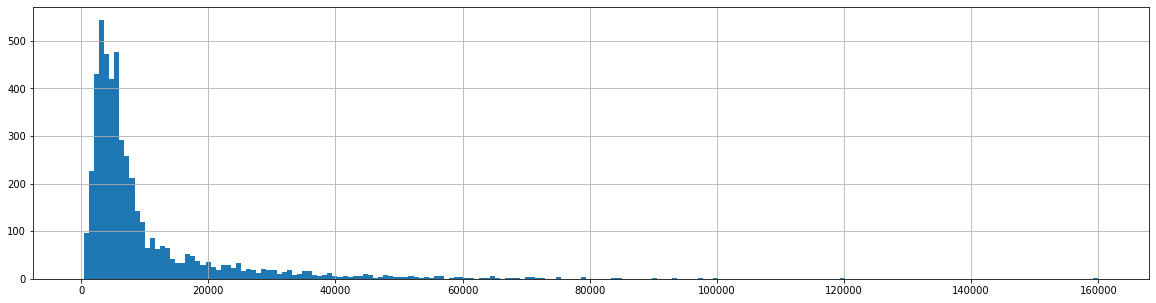

In [8]:
data_input.loc[:, "Price"].hist(figsize=(20,5), bins=200)

The distribution is obviously skewed so we it seems rather obvious that we could easily drop some obvious outliers.

<AxesSubplot:>

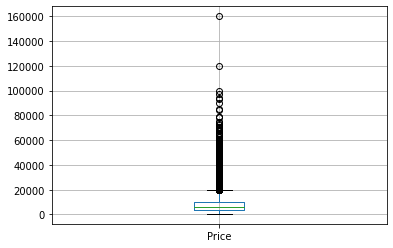

In [9]:
data_input.boxplot(column=[label_name])

In [10]:
# the unique names of the cars are
print(len(data_input["Name"].unique()))
# if there weren't so many they could actually have proven useful as a feature.
# But if we tried to use them, due to the curse of dimentionality we would definately had a serious problem with our model.

1661


The way we could actually take advantage of this feature is by extracting the actual brand of the car alone 
and check if it actually helps the model perform better

In [11]:
names = [i.lower().split(" ") for i in data_input["Name"].unique()]
syllabi = [j for i in names for j in i]
set_syllabi = set(syllabi)
counter_syllabi = Counter(syllabi)
counter_syllabi = list(counter_syllabi.items())
counter_syllabi = sorted([(i[-1],i[0]) for i in counter_syllabi])

In [12]:
counter_syllabi[::-1]

[(270, 'maruti'),
 (239, 'hyundai'),
 (162, 'at'),
 (140, 'honda'),
 (116, 'tdi'),
 (107, '1.2'),
 (106, 'toyota'),
 (106, 'mercedes-benz'),
 (99, 'ford'),
 (95, 'tata'),
 (95, 'diesel'),
 (94, 'mahindra'),
 (93, 'plus'),
 (89, 'mt'),
 (78, '1.6'),
 (77, 'skoda'),
 (76, 'bmw'),
 (73, 's'),
 (71, '1.5'),
 (66, 'crdi'),
 (66, '1.4'),
 (64, 'i20'),
 (63, 'volkswagen'),
 (63, 'audi'),
 (62, '2.0'),
 (59, 'option'),
 (58, 'vxi'),
 (55, 'sx'),
 (53, 'lxi'),
 (52, 'swift'),
 (50, 'series'),
 (47, 'verna'),
 (47, 'petrol'),
 (47, 'city'),
 (45, 'i10'),
 (44, 'cdi'),
 (43, 'sport'),
 (42, 'edition'),
 (40, 'rover'),
 (40, 'bsiii'),
 (39, 'vx'),
 (39, 'nissan'),
 (39, 'innova'),
 (38, 'titanium'),
 (38, 'renault'),
 (38, 'chevrolet'),
 (37, 'new'),
 (36, 'zxi'),
 (36, 'i'),
 (35, 'v'),
 (35, 'bsiv'),
 (35, 'asta'),
 (35, '200'),
 (33, 'seater'),
 (33, 'elegance'),
 (32, 'sportz'),
 (32, 'scorpio'),
 (32, 'r'),
 (32, 'magna'),
 (31, 'wagon'),
 (31, 'e-class'),
 (30, 'dzire'),
 (30, 'bs'),
 (29, '

In [13]:
# it is obvious that we could manually hand pick the brands of the cars, but since those names weren't in a sentence
# we can't do it in a non manual way (we could use NER instead).

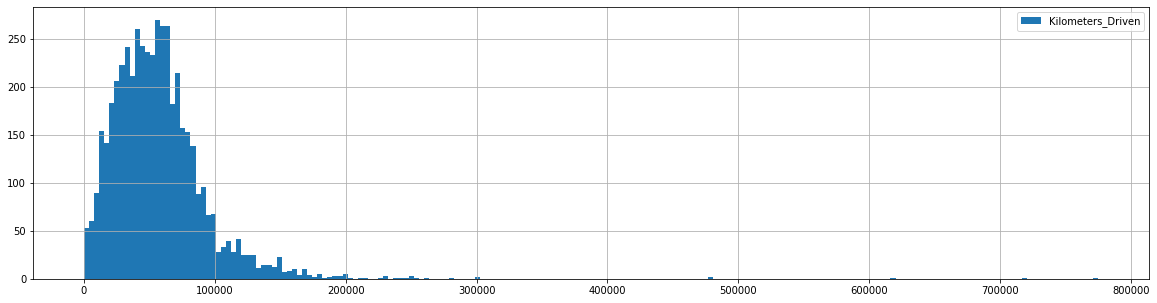

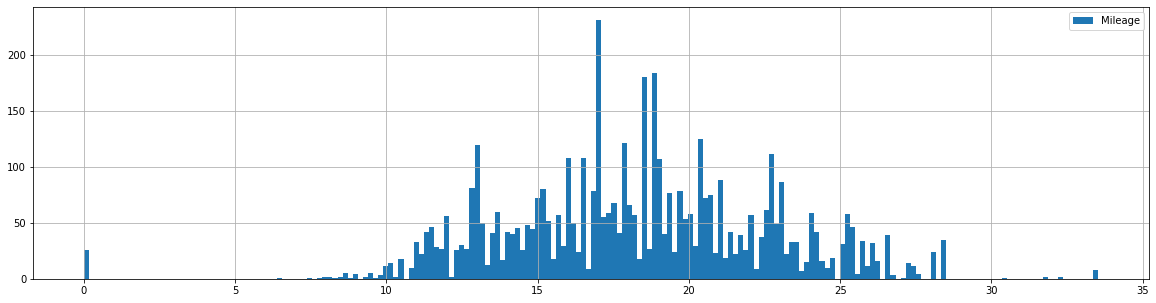

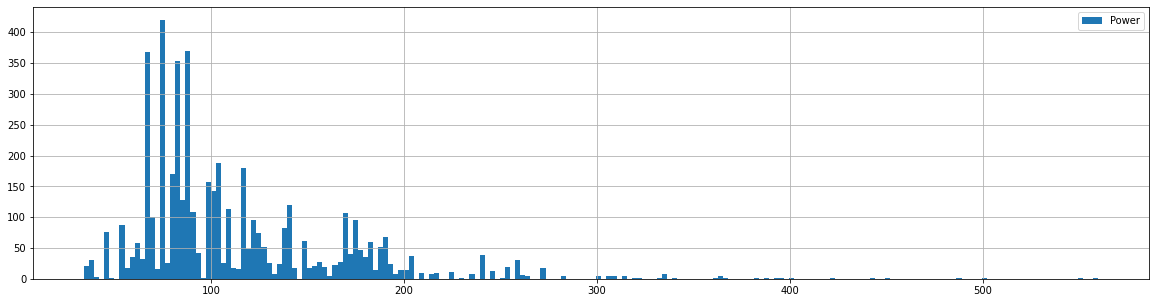

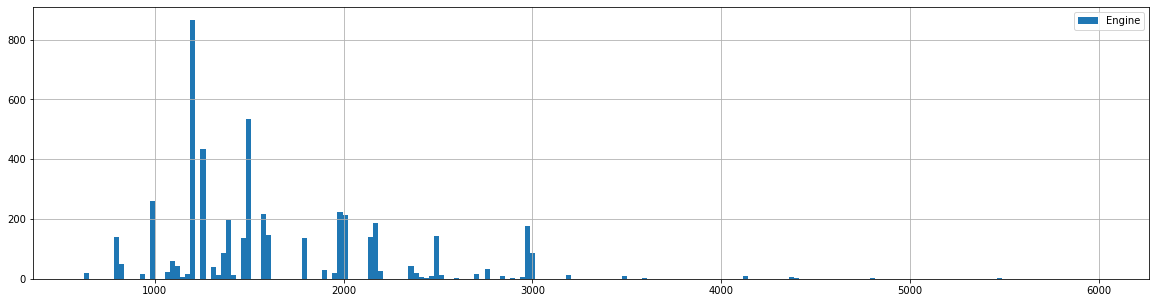

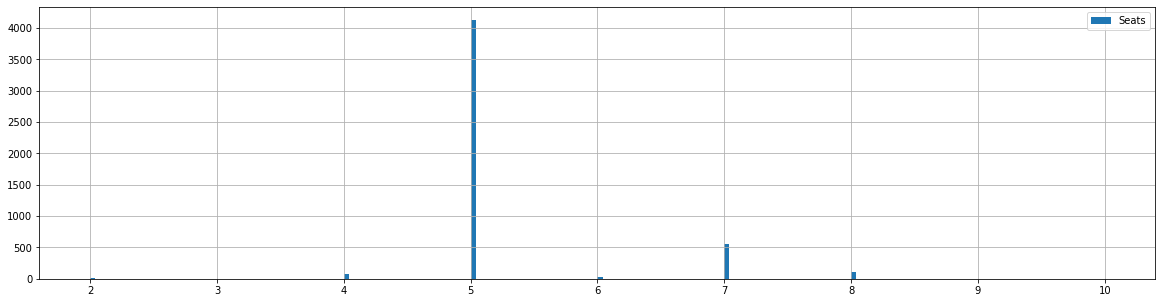

In [14]:
for i in continuous_variables:
    data_input.loc[:, i].hist(figsize=(20,5), bins=200, legend=i)
    plt.show()

Now we have to check wether there is a correlation between our features and our labels using scatter plots

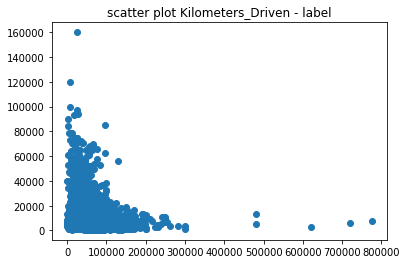

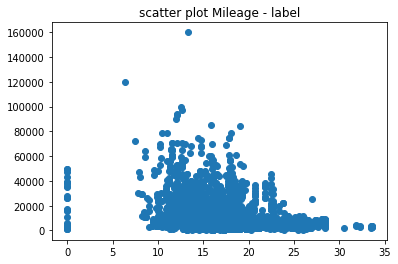

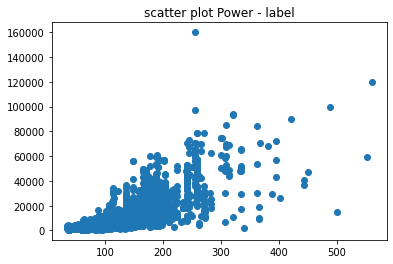

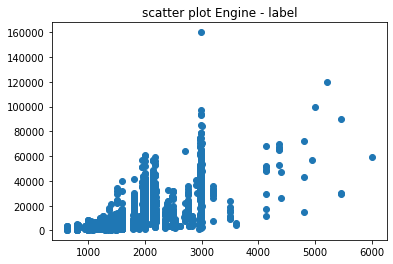

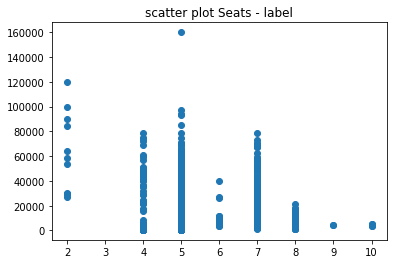

In [15]:
for i in continuous_variables:
    plt.title("scatter plot %s - label"%i)
    plt.scatter(data_input.loc[:, i].values, data_input.loc[:, label_name].values)
    plt.show()

There seems to be a severe correlation of Power and price

before we go any further and prepare for our model we need to encode all our categorical variables

In [16]:
data_input = data_input.loc[:, data_input.columns != "Name"]

In [17]:
data_input.loc[:, continuous_variables].describe()

,Kilometers_Driven,Mileage,Power,Engine,Seats
count,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000
mean,57325.883432,18.280715,112.853436,1621.659874,5.279193
std,38433.648533,4.391050,53.763071,599.531875,0.798172
min,171.000000,0.000000,34.200000,624.000000,2.000000
25%,33000.000000,15.260000,74.980000,1198.000000,5.000000
50%,53000.000000,18.200000,94.000000,1493.000000,5.000000
75%,72467.000000,21.100000,138.100000,1968.000000,5.000000
max,775000.000000,33.540000,560.000000,5998.000000,10.000000


Show the correlation between the continuous data and the label. Correlation does not imply causation but we do get a very strong sense of the important features here, features with more variance tend to give more information to the  model.

In [18]:
data_input.loc[:, continuous_variables+["Price"]].corr()[label_name]

Kilometers_Driven   -0.163542
Mileage             -0.338404
Power                0.774266
Engine               0.658710
Seats                0.052659
Price                1.000000
Name: Price, dtype: float64

In [19]:
cat_df = data_input.loc[:, categorical_variables].copy()

In [20]:
cat_df.apply(LabelEncoder().fit_transform)

,Fuel_Type,Transmission,Owner_Type
0,3,1,1
1,1,1,0
2,3,0,0
3,3,1,0
4,1,0,0
...,...,...,...
4902,1,1,1
4903,1,0,0
4904,1,0,0
4905,3,1,0


In [21]:
enc = OneHotEncoder()
enc.fit(cat_df)
onehotlabels = enc.transform(cat_df).toarray()

In [22]:
model_ready_data = pd.concat([data_input.loc[:, continuous_variables],pd.DataFrame(onehotlabels)],axis=1)
model_ready_data = pd.concat([model_ready_data, data_input.loc[:, label_name]], axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(model_ready_data.loc[:, model_ready_data.columns!=label_name], data_input.loc[:, label_name], test_size=0.2, random_state=42)

first run without any scaling/outlier removal etc

running with LinearRegression 
Training MAE 3823.7358066570805
Training mean squared error 40483169.40653551
validation MAE 4093.1546961260456
validation explained variance: r2 , 0.32310240998061224
validation mean squared error 60072906.6642027
lr coefs
['Kilometers_Driven', 'Mileage', 'Power', 'Engine', 'Seats', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[-0.04656115499402622, 60.73615533737824, 132.6853486813396, 0.647073708897075, -204.12214979275552, 570.2102752204954, 1014.096790178177, 673.3042196222966, -2257.6112850209693, 1643.8928899019115, -1643.8928899019127, 1463.6595002831418, -367.32262901549694, -643.747335863111, -452.5895354045339]


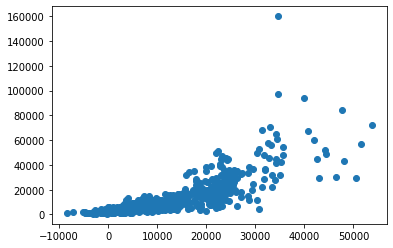

running with XGBRegressor 
Training MAE 928.0847986695113
Training mean squared error 1902124.446454145
validation MAE 2262.5060433506237
validation explained variance: r2 , 0.7986895427144798
validation mean squared error 25823205.903634854


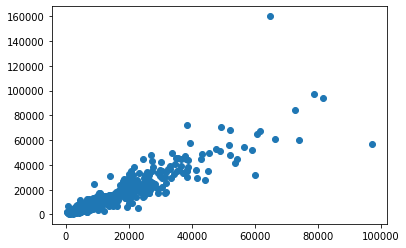

running with SVR 
Training MAE 5938.170098988444
Training mean squared error 136250287.9500156
validation MAE 6559.170987121804
validation explained variance: r2 , -19151.476097941348
validation mean squared error 182324961.29892996


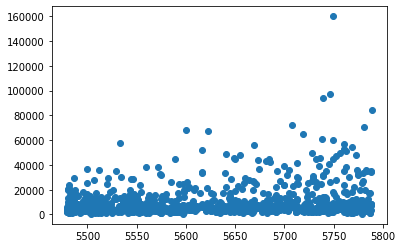

In [24]:
for model in [LinearRegression, XGBRegressor, SVR]:
    nm = model.__name__
    print("running with %s "%nm)
    model = model()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("Training MAE", mean_absolute_error(model.predict(X_train), y_train))
    print("Training mean squared error", mean_squared_error(model.predict(X_train), y_train))


    print("validation MAE", mean_absolute_error(y_pred, y_test))
    print("validation explained variance: r2 ,",r2_score(y_pred, y_test))
    print("validation mean squared error", mean_squared_error(y_pred, y_test))

    if "linear" in nm.lower():
        print("lr coefs")
        print(list(X_train.columns))
        print(list(model.coef_))

    plt.scatter(y_pred,y_test)
    plt.show()

In [25]:
# obviously fails because SVMs' are very sensitive to unscaled data.

Before feeding it to models we will have to scale them in order not to punish the other features.
But it is paramount to create two scalers in order not to have information leakage.

We use RobustScaler since it's better on handling outliers

In [26]:
scx_train = RobustScaler()
scx_test = RobustScaler()

scy_train = RobustScaler()
scy_test = RobustScaler()


X_train_scaled = scx_train.fit_transform(X_train)
y_train_scaled = scy_train.fit_transform(y_train.values.reshape(-1,1))


X_test_scaled = scx_test.fit_transform(X_test)
y_test_scaled = scy_test.fit_transform(y_test.values.reshape(-1,1))


running with LinearRegression 
val mae 4613.931120878418
val r2 0.5296492219996984
val mean squared error 61394447.72988577


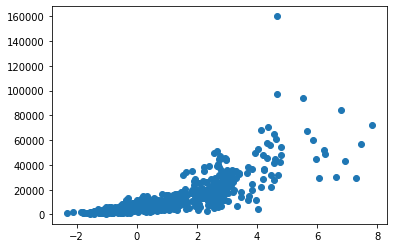

running with XGBRegressor 
val mae 3259.700651770939
val r2 0.7667767813674233
val mean squared error 41288769.401311114


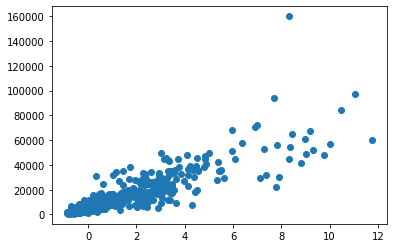

running with SVR 
val mae 3022.749816835749
val r2 0.6504990291945678
val mean squared error 41696677.01972495


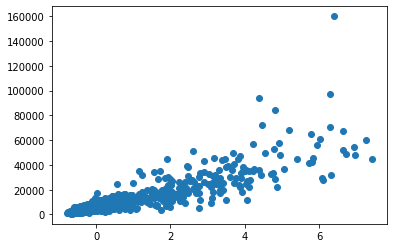

In [27]:
for model in [LinearRegression, XGBRegressor, SVR]:
    nm = model.__name__
    print("running with %s "%nm)
    model = model()
    model.fit(X_train_scaled, y_train_scaled)
    y_pred = model.predict(X_test_scaled)
    
    
    tp = (scy_test.inverse_transform(y_pred.reshape(-1,1)), 
          scy_test.inverse_transform(y_test_scaled.reshape(-1,1))
         )
    
    print("val mae", mean_absolute_error(tp[0], tp[1]))
    print("val r2", r2_score(tp[0], tp[1]))
    print("val mean squared error", mean_squared_error(tp[0], tp[1]))
    
    plt.scatter(y_pred,y_test)
    plt.show()

In order to fix the outliers on the labels we put the in log function

In [28]:
data_input.loc[:, label_name] = data_input.loc[:, label_name].apply(np.log)
X_train, X_test, y_train, y_test = train_test_split(model_ready_data.loc[:, model_ready_data.columns!=label_name], data_input.loc[:, label_name], test_size=0.2, random_state=42)

using log transformation on the labels we eliminate the outliers, but since our features *also have outliers* we can still use RobustScaler on them

running with LinearRegression 
Training MAE 3354.6654559677877
Training mean squared error 211153935.7534298
validation MAE 3597.0587910887384
validation explained variance: r2 , 0.7140830410738848
validation mean squared error 66388081.22624618


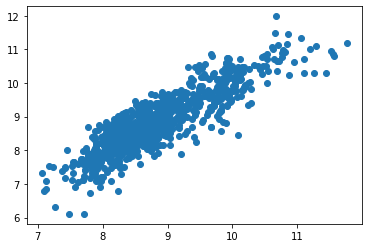

running with XGBRegressor 
Training MAE 1056.025234460527
Training mean squared error 211151434.54248506
validation MAE 2255.3023011621294
validation explained variance: r2 , 0.8706776656237705
validation mean squared error 30556251.08547934


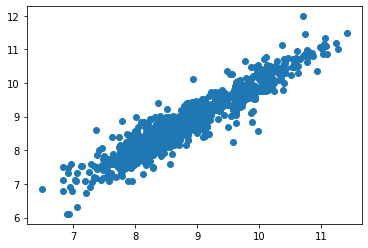

running with SVR 
Training MAE 5199.297228829814
Training mean squared error 211164317.55087277
validation MAE 5721.385793395838
validation explained variance: r2 , -5.495002144118483
validation mean squared error 145304040.74163148


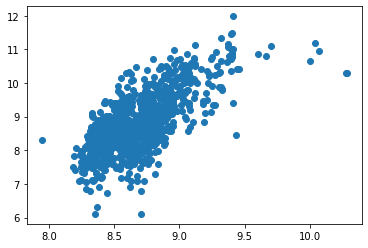

In [29]:
for model in [LinearRegression, XGBRegressor, SVR]:
    nm = model.__name__
    print("running with %s "%nm)
    model = model()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("Training MAE", mean_absolute_error(np.exp(model.predict(X_train)), np.exp(y_train)))
    print("Training mean squared error", mean_squared_error(model.predict(X_train), np.exp(y_train)))


    print("validation MAE", mean_absolute_error(np.exp(y_pred), np.exp(y_test)))
    print("validation explained variance: r2 ,",r2_score(y_pred, y_test))
    print("validation mean squared error", mean_squared_error(np.exp(y_pred), np.exp(y_test)))


    plt.scatter(y_pred,y_test)
    plt.show()

scale and put labels on log

In [30]:
X_train, X_test, y_train, y_test = train_test_split(model_ready_data.loc[:, model_ready_data.columns!=label_name], data_input.loc[:, label_name], test_size=0.2, random_state=42)

scx_train = RobustScaler()
scx_test = RobustScaler()

X_train = scx_train.fit_transform(X_train)

X_test = scx_train.fit_transform(X_test)

running with LinearRegression 
Training MAE 3354.6654559677736
Training mean squared error 85867424.52594972
validation MAE 3659.0703314925418
validation explained variance: r2 , 0.7205557191976204
validation mean squared error 70546113.22402279


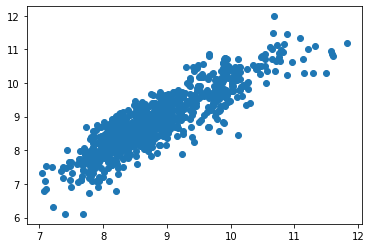

running with XGBRegressor 
Training MAE 1056.025234460527
Training mean squared error 3671013.040017501
validation MAE 3025.3802129741593
validation explained variance: r2 , 0.7636522837235783
validation mean squared error 36981052.622081146


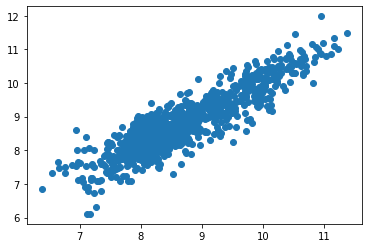

running with SVR 
Training MAE 2412.4180766623435
Training mean squared error 22668298.758538157
validation MAE 2829.2898369588665
validation explained variance: r2 , 0.7983908546400694
validation mean squared error 43231683.54336309


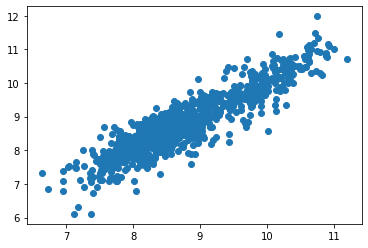

In [31]:
for model in [LinearRegression, XGBRegressor, SVR]:
    nm = model.__name__
    print("running with %s "%nm)
    model = model()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("Training MAE", mean_absolute_error(np.exp(model.predict(X_train)), np.exp(y_train)))
    print("Training mean squared error", mean_squared_error(np.exp(model.predict(X_train)), np.exp(y_train)))


    print("validation MAE", mean_absolute_error(np.exp(y_pred), np.exp(y_test)))
    print("validation explained variance: r2 ,",r2_score(y_pred, y_test))
    print("validation mean squared error", mean_squared_error(np.exp(y_pred), np.exp(y_test)))


    plt.scatter(y_pred,y_test)
    plt.show()

Scaling both features and labels with methods that handle outliers seems to produce the best results so far.
We can go on and improve our models further by pruning features that deem unecessary using the information gained from
the correlation matrices and by producing the feature importances from xgboost

The best model was by far XGBoost when i applied log on the labels (smoothed the outliers).

In [32]:

parameters = {
    "learning_rate": [0.005, 0.01, 0.09],
    "max_depth": [4, 5, 6, 7],
    "n_estimators": [100, 500, 1000]
}

dt = model_ready_data.loc[:, :].copy()

X_train, X_test, y_train, y_test = train_test_split(dt.loc[:, dt.columns!=label_name], data_input.loc[:, label_name], test_size=0.2, random_state=42)


xgbr = GridSearchCV(XGBRegressor(), param_grid=parameters, cv=5, verbose=1)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [33]:
print("validation MAE", mean_absolute_error(np.exp(y_pred), np.exp(y_test)))
print("validation explained variance: r2 ,",r2_score(y_pred, y_test))
print("validation mean squared error", mean_squared_error(np.exp(y_pred), np.exp(y_test)))

validation MAE 2266.7945909674927
validation explained variance: r2 , 0.8699555180409699
validation mean squared error 31901936.39881933


In [34]:
model_ready_data

,Kilometers_Driven,Mileage,Power,Engine,Seats,0,1,2,3,4,5,6,7,8,9,Price
0,60000,19.81,68.05,1086,5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2650.0
1,73500,13.00,168.50,2982,7,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,22000.0
2,28888,10.00,157.70,2496,5,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,7560.0
3,41000,16.47,73.90,1198,5,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,3100.0
4,52000,15.68,177.00,1999,5,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,42000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4902,250000,12.99,100.60,2494,8,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,7900.0
4903,38000,14.84,170.00,2143,5,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,13510.0
4904,40674,11.36,171.50,2755,7,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,24820.0
4905,62505,17.40,117.30,1497,5,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5950.0
